In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
import pickle
import os
from scipy.stats import norm
import seaborn as sns

#from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization
#from pyqg_parameterization_benchmarks.utils import energy_budget_figure
#from pyqg_parameterization_benchmarks.neural_networks import FullyCNN


%matplotlib inline
plt.rcParams.update({'font.size': 13})
%run nnClass.ipynb
%run utils.ipynb

/Users/peterjin/opt/anaconda3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


---
# <u>Contents</u>
### 1. [Data](#1)
- 1.0 [Data (from benchmarking testing)](#1.0)
- 1.1 [Data processing](#1.1)
- 1.2 [Data processing compared with benchmarking data processing](#1.2)

### 2. [WDL (on our processed data)](#2)
### 3. [NN (class)](#3)
- 1.0 [Data](#3.0)
- 1.1 [Testing](#3.1)

### 4. [WDL (class)](#4)
### 5. [NN+WDL (class)](#5)
### 6. [PCA/CCA](#6)

---
## 1. Data processing to test WDL <a class="anchor" id="1"></a>

>##### 1.0 Pull in data from benchmarking testing <a class="anchor" id="1.0"></a>
>
>- [Github](https://github.com/m2lines/pyqg_parameterization_benchmarks/blob/master/notebooks/dataset_description.ipynb) (eddy/forcing1 is used here)

In [2]:
# to check against something we know, let's get the dataset given by benchmarking
def get_dataset(path, base='datasets'):
    mapper = fsspec.get_mapper(f"{base}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

In [3]:
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

/Users/peterjin/opt/anaconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# this is already trained, we are just pulling this in to check out inputs, targets
with open('../pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1/models/0/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('../pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1/models/0/targets.pkl', 'rb') as f:
    targets = pickle.load(f)
    
model_dir = '../pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1/models/0'
param = FullyCNN.load(model_dir)
#inputs = param.extract_inputs(eddy_forcing1)
#targets = param.extract_targets(eddy_forcing1)

print(inputs)
print(targets)

[('q', 0), ('q', 1)]
[('q_forcing_total', 0)]


>##### 1.1 Processing bit <a class="anchor" id="1.1"></a>:
>- pre: split over layers + flattened over time, space
>- post: split over layers, 87 time slices + flattened over space

In [5]:
qhiresfcg = []
tarhiresfcg = []
for z in [0,1]: # 2 layers
    qhiresfcg.append(FeatureExtractor(eddy_forcing1.isel(lev=z))('q').ravel())
    tarhiresfcg.append(FeatureExtractor(eddy_forcing1.isel(lev=z))('q_forcing_total').ravel())
qhiresfcglayer1 = np.split(qhiresfcg[0],87) # split across 87 time slices
qhiresfcglayer2 = np.split(qhiresfcg[1],87)
tarhiresfcglayer1 = np.split(tarhiresfcg[0],87)
tarhiresfcglayer2 = np.split(tarhiresfcg[1],87)

In [6]:
print(np.shape(qhiresfcg)) # shape: (2, 87*4096)

(2, 356352)


In [7]:
qhiresfcglayer1 = np.asarray(qhiresfcglayer1)
qhiresfcglayer2 = np.asarray(qhiresfcglayer2)
tarhiresfcglayer1 = np.asarray(tarhiresfcglayer1)
tarhiresfcglayer2 = np.asarray(tarhiresfcglayer2)

In [8]:
print(np.shape(qhiresfcglayer1)) # shape: (87, 4096)

(87, 4096)


>##### 1.2 Compare against Benchmarking data processing (sanity check) <a class="anchor" id="1.2"></a>:
>- check shapes: benchmarking still flattens over time (average)
>- check kde: spike @0
>- check std: increasing?

In [9]:
# benchmarking
T = 87
for z in [0,1]:
    # Flatten over space and the last T timesteps
    ts = slice(-T,None) 
    q1 = FeatureExtractor(eddy_forcing1.isel(lev=z,time=ts))('q').ravel()

In [10]:
print(q1.shape) # shape looks good, note: benchmarking looks at several timesteps at once

(356352,)


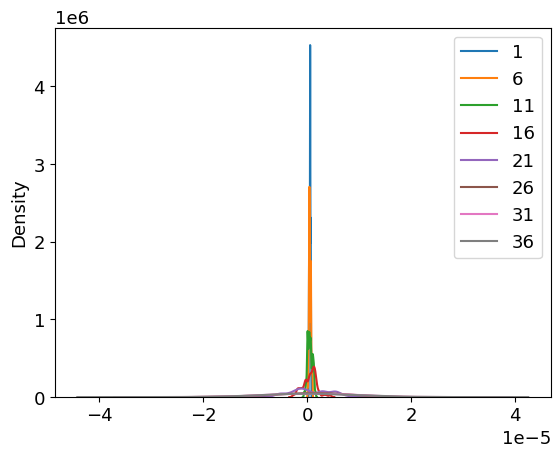

In [11]:
fig, ax = plt.subplots()

for t in range(1,40,5):
    sns.kdeplot(qhiresfcglayer1[t], ax=ax, label=str(t))
ax.legend()

<AxesSubplot:ylabel='Density'>

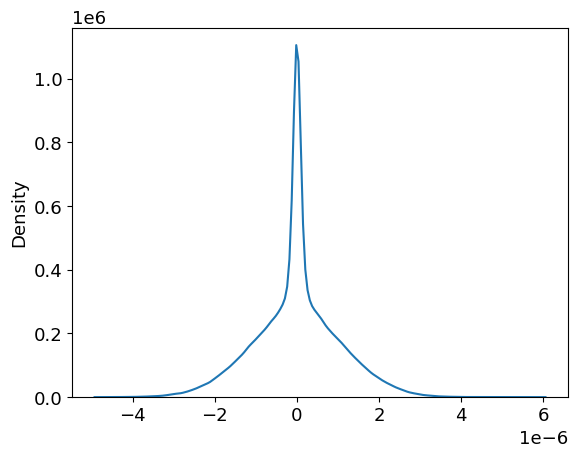

In [12]:
# benchmarking: combined over last 10000 units of time

fig, ax = plt.subplots()
sns.kdeplot(q1, ax=ax)
#for t in range(1,40,5):
#    sns.kdeplot(q1[t], ax=ax, label=str(t))
#ax.legend()

#>2 components

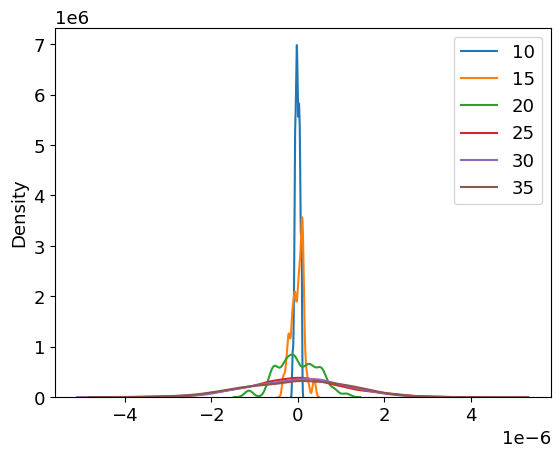

In [13]:
# benchmarking: separated by time steps
fig, ax = plt.subplots()

for t in range(10,40,5):
    for z in [0,1]:
    # Flatten over space 
        q1 = FeatureExtractor(eddy_forcing1.isel(lev=z,time=t))('q').ravel()
    sns.kdeplot(q1, ax=ax, label=str(t))
ax.legend()

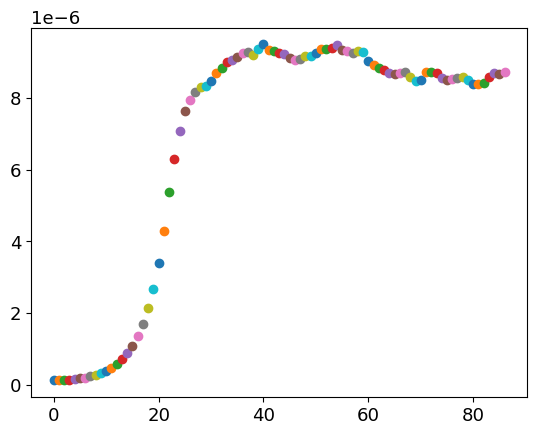

In [14]:
for t in range(0,87):
    plt.scatter(t, np.std(qhiresfcglayer1[t]))

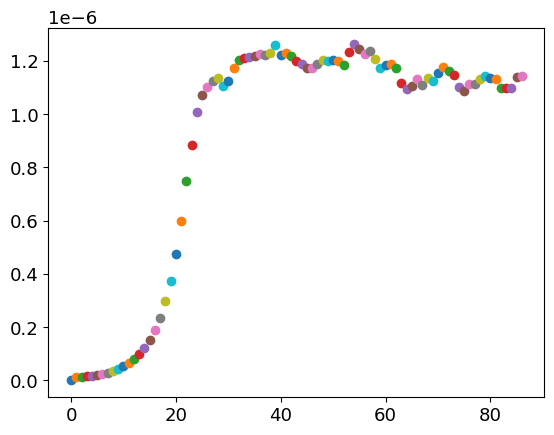

In [15]:
for t in range(0,87):
    for z in [0,1]:
    # Flatten over space 
        q1 = FeatureExtractor(eddy_forcing1.isel(lev=z,time=t))('q').ravel()
    plt.scatter(t, np.std(q1), label=str(t))
ax.legend()

In [16]:
#print(qhiresfcglayer1) # scale: order -7 to -5

In [17]:
#print(tarhiresfcglayer1) # scale: order -17 to -11

---
## 2. WDL <a class="anchor" id="2"></a>
- Note: conducted on the data processed in part 1

In [18]:
%run WDL.ipynb

X = qhiresfcglayer1
# X2 = qhiresfcglayer2
Y = tarhiresfcglayer1
# Y2 = tarhiresfcglayer2

n_dist = Y.shape[0]
n_levs = 100
q_vec = torch.arange(1, n_levs, dtype=torch.float64) / n_levs # quantile levels

# transform Y
Q_mat = np.array([np.quantile(Y[i], q_vec) for i in range(n_dist)]) # calculate the empirical quantile function

K_mix = 2
n_iter = 1000
#lr = 1e-1
#v_lr = np.array([1] + [lr] * n_iter)

In [19]:
# train-test split

n_train = int(0.8 * n_dist)
loc_train = np.random.choice(n_dist, n_train, replace=False)
loc_val = np.setdiff1d(np.arange(n_dist), loc_train)


X_train = torch.tensor(X[loc_train])
# generate true parameters
mu_true = torch.cat((X_train[:, 0].unsqueeze(dim=1), (2 * X_train[:, 1] ** 2 + 2).unsqueeze(dim=1)), dim=1)
sd_true = torch.cat(
    (torch.abs(X_train[:, 1]).unsqueeze(dim=1) + 0.5, torch.abs(X_train[:, 0]).unsqueeze(dim=1) + 0.5), dim=1)
alpha_true = torch.cat((torch.zeros_like(X_train[:, 2].unsqueeze(dim=1)), X_train[:, 2].unsqueeze(dim=1)), dim=1)
pi_true = torch.softmax(alpha_true, dim=1)

# generate features
X_train = torch.cat((X_train, torch.abs(X_train), X_train ** 2), 1)
y_train = torch.tensor(Q_mat[loc_train])
X_val = torch.tensor(X[loc_val])
X_val = torch.cat((X_val, torch.abs(X_val), X_val ** 2), 1)
y_val = torch.tensor(Q_mat[loc_val])

In [20]:
# 1. train

alpha_matrix = torch.tensor(np.random.randn(len(X_train[0]), 2), requires_grad=True) # scale this down 10^-6
mu_matrix = torch.tensor(np.random.randn(len(X_train[0]), 2), requires_grad=True)
sd_matrix = torch.tensor(np.random.randn(len(X_train[0]), 2), requires_grad=True)

optimizer = torch.optim.SGD([alpha_matrix, mu_matrix, sd_matrix], lr=0.6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=170, gamma=0.84)

# train the model
for k in range(1000):
    alpha = torch.matmul(X_train, alpha_matrix.float())
    mu = torch.matmul(X_train, mu_matrix.float())
    sd = torch.abs(torch.matmul(torch.abs(X_train), sd_matrix.float()))

    pi = torch.softmax(alpha, dim=1)

    optimizer.zero_grad()
    loss = WDL(y_train, q_vec, mu, sd, pi)
    # print(k, loss.item()) # note: we want a decreasing sequence
    loss.backward()
    optimizer.step()
    scheduler.step()

---
## 3. NN <a class="anchor" id="3"></a>

In [21]:
# 2. initialize FCNN 
in_q = ['q','u','v']
tar_q_tot = ['q_forcing_total']

#fcnn_q_qtot = FullyCNN(inputs=in_q, targets=tar_q_tot)
#fcnn_q_qtot.save('./models/fcnn_q_qtot')

In [22]:
fcnn_param = FCNNParameterization('./models/fcnn_q_qtot')

In [23]:
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

In [24]:
fcnn_param = fcnn_param.train_on(dataset = eddy_forcing1, inputs=in_q, targets=tar_q_tot, directory = './models/fcnn_q_qtot')

Loss after Epoch 1: 1.2675414681434631
Loss after Epoch 2: 1.0590338706970215
Loss after Epoch 3: 1.0268167555332184
Loss after Epoch 4: 0.9190455377101898
Loss after Epoch 5: 1.0172602236270905
Loss after Epoch 6: 1.031285673379898
Loss after Epoch 7: 0.9764537215232849
Loss after Epoch 8: 0.9320361912250519
Loss after Epoch 9: 0.9057109951972961
Loss after Epoch 10: 0.8866294920444489
Loss after Epoch 11: 0.7472585439682007
Loss after Epoch 12: 0.682352751493454
Loss after Epoch 13: 0.6208743155002594
Loss after Epoch 14: 0.5604813098907471
Loss after Epoch 15: 0.540289968252182
Loss after Epoch 16: 0.5268808305263519
Loss after Epoch 17: 0.4743051379919052
Loss after Epoch 18: 0.4352700412273407
Loss after Epoch 19: 0.42108944058418274
Loss after Epoch 20: 0.4339764714241028
Loss after Epoch 21: 0.3782542794942856
Loss after Epoch 22: 0.3656116873025894
Loss after Epoch 23: 0.3813707083463669
Loss after Epoch 24: 0.36417245864868164
Loss after Epoch 25: 0.3413361757993698
Loss after

>###### 3.0 Get testing data <a class="anchor" id="3.0"></a>
>- see forcing_data.ipynb

In [25]:
%run forcing_data.ipynb

In [26]:
testing_data = generate_forcing_data()

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 1.25e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 2000, Time: 7.20e+06, KE: 1.36e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 3000, Time: 1.08e+07, KE: 1.69e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 4000, Time: 1.44e+07, KE: 2.22e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 5000, Time: 1.80e+07, KE: 3.06e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 6000, Time: 2.16e+07, KE: 4.43e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 7000, Time: 2.52e+07, KE: 6.68e-07, CFL: 0.023
INFO:  Logger i

INFO:  Logger initialized
INFO: Step: 60000, Time: 2.16e+08, KE: 6.02e-04, CFL: 0.263
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 61000, Time: 2.20e+08, KE: 6.03e-04, CFL: 0.261
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 62000, Time: 2.23e+08, KE: 5.97e-04, CFL: 0.238
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 63000, Time: 2.27e+08, KE: 6.05e-04, CFL: 0.238
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 64000, Time: 2.30e+08, KE: 6.30e-04, CFL: 0.222
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 65000, Time: 2.34e+08, KE: 6.01e-04, CFL: 0.209
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 66000, Time: 2.38e+08, KE: 5.93e-04, CFL: 0.210
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: St

In [27]:
testing_data[0]['q_forcing_total'] = testing_data[0].dqdt_bar - testing_data[0].dqbar_dt

>###### 3.1 Test <a class="anchor" id="3.1"></a>
>1. eddy_forcing1 (benchmarking data)
>2. testing_data (generated via own code)

In [28]:
preds_q_qtot = fcnn_param.test_offline(eddy_forcing1)

In [29]:
print(preds_q_qtot)

<xarray.Dataset>
Dimensions:                               (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                   (lev) int32 1 2
  * time                                  (time) float32 0.0 ... 3.096e+08
  * x                                     (x) float32 7.812e+03 ... 9.922e+05
  * y                                     (y) float32 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_forcing_total                       (time, lev, y, x) float32 -2.647e-1...
    q_forcing_total_predictions           (time, lev, y, x) float32 9.511e-13...
    q_forcing_total_spatial_mse           (lev, y, x) float32 2.033e-23 ... 4...
    q_forcing_total_temporal_mse          (time, lev) float32 3.303e-26 ... 3...
    q_forcing_total_mse                   (lev) float32 1.61e-23 2.544e-27
    q_forcing_total_spatial_skill         (lev, y, x) float32 0.3364 ... 0.625
    ...                                    ...
    q_forcing_total_spatial_correlation   (lev, y, x) flo

In [30]:
# plot helpers 

def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')

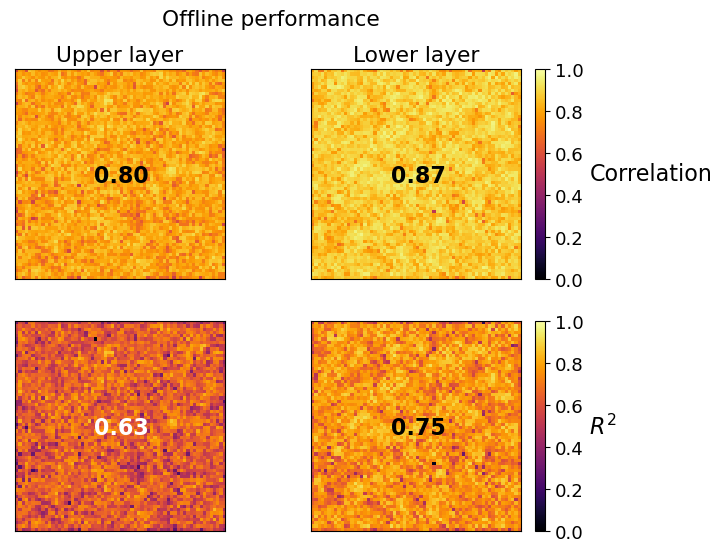

In [31]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds_q_qtot.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds_q_qtot.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

In [32]:
with open('./models/fcnn_q_qtot/models/0/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('./models/fcnn_q_qtot/models/0/targets.pkl', 'rb') as f:
    targets = pickle.load(f)

print(inputs)
print(targets)

[('q', 0), ('q', 1), ('u', 0), ('u', 1), ('v', 0), ('v', 1)]
[('q_forcing_total', 0)]


---
## 4. WDL <a class="anchor" id="4"></a>

In [62]:
%run nnClassWOnly.ipynb

In [63]:
fcnn_param_wonly = FCNNParameterization_w('./models/fcnn_q_qtot_wonly')

In [ ]:
fcnn_param_wonly = fcnn_param_wonly.train_on(dataset = eddy_forcing1, inputs=in_q, targets=tar_q_tot, directory = './models/fcnn_q_qtot_wonly')

yhat: tensor([[ 0.0266, -0.0967,  0.2356,  ...,  0.2592,  0.7918,  1.0390],
        [ 0.1465,  0.4250, -0.0546,  ..., -0.8875, -0.5921, -0.0834],
        [ 0.2394, -0.6983, -0.5763,  ..., -0.1503, -0.2191,  0.2856],
        ...,
        [ 0.4607,  0.7604,  0.6663,  ...,  0.1067,  0.5597,  0.1078],
        [-0.1190,  0.1905,  0.3230,  ..., -0.1330, -0.1154,  0.0284],
        [ 0.0323, -0.5226, -0.1405,  ...,  0.1517,  0.2844, -0.1047]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.9528, -2.5520, -2.2566,  ...,  2.2463,  2.5421,  3.0651],
        [-3.2715, -2.7263, -2.3658,  ...,  2.3995,  2.7110,  3.1713],
        [-2.9076, -2.4632, -2.2426,  ...,  2.0950,  2.4199,  2.8275],
        ...,
        [-3.5447, -3.0508, -2.7121,  ...,  2.6438,  2.9104,  3.6467],
        [-0.0491, -0.0348, -0.0262,  ...,  0.0272,  0.0360,  0.0524],
        [-2.7740, -2.2548, -2.0055,  ...,  2.0893,  2.2986,  2.7086]],
       dtype=torch.float64)
mu: tensor([[ 41.3444,  33.1878, -15.7790],
        [ 10.0

yhat: tensor([[-0.1100,  0.2263,  0.1608,  ...,  1.1402,  0.1732,  0.1898],
        [ 0.4892,  1.5894,  0.3587,  ...,  0.5411,  0.0539, -0.0667],
        [ 0.2932,  0.4990,  0.0986,  ...,  0.3276, -0.2668,  0.2234],
        ...,
        [-0.2134,  0.0072,  0.0640,  ...,  0.1690,  0.1636,  0.2004],
        [ 0.3266,  0.6313,  0.5892,  ...,  0.3605, -0.7375, -0.4913],
        [-0.3171, -0.1981,  0.1168,  ...,  0.1952,  0.1836,  0.2044]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.4917e+00, -2.8982e+00, -2.6017e+00,  ...,  2.6374e+00,
          3.0131e+00,  3.5373e+00],
        [-2.8750e+00, -2.4587e+00, -2.2011e+00,  ...,  2.2397e+00,
          2.5822e+00,  3.2539e+00],
        [-2.9006e+00, -2.4430e+00, -2.1802e+00,  ...,  2.1123e+00,
          2.3254e+00,  2.7908e+00],
        ...,
        [-1.0116e-04, -8.5209e-05, -7.8613e-05,  ...,  8.2579e-05,
          8.8342e-05,  1.0096e-04],
        [-3.5736e+00, -2.9152e+00, -2.6146e+00,  ...,  2.5525e+00,
          2.9961e+00,  3.550

yhat: tensor([[-7.3196e-01,  2.0812e-01,  8.3085e-01,  ...,  8.8015e-02,
          6.2904e-01,  1.2339e-01],
        [-1.4633e-01,  1.6265e-01, -1.2556e-01,  ..., -6.0482e-02,
          1.4794e-01, -4.7404e-02],
        [-4.9920e-01,  1.9555e-01,  4.6139e-01,  ..., -4.6467e-01,
         -9.5233e-01,  4.1786e-02],
        ...,
        [ 5.7706e-01,  2.5773e-01, -1.6943e-01,  ..., -5.4798e-01,
          5.8858e-04,  4.2375e-01],
        [-4.0900e-01, -6.3591e-01, -7.0381e-01,  ..., -6.8887e-01,
          3.4879e-01, -9.5549e-02],
        [ 2.9261e-01, -4.2757e-01, -1.5337e-01,  ...,  3.7999e-01,
          3.9367e-02,  5.8706e-02]], grad_fn=<MulBackward0>)
y_train: tensor([[-3.8223, -3.1262, -2.7693,  ...,  2.7914,  3.1468,  3.8282],
        [-2.7999, -2.1769, -1.8820,  ...,  1.9574,  2.2726,  2.7592],
        [-2.8606, -2.2589, -2.0158,  ...,  2.0411,  2.2952,  2.6458],
        ...,
        [-3.3940, -2.9045, -2.5257,  ...,  2.5503,  2.8411,  3.2661],
        [-3.6225, -2.9983, -2.5943, 

yhat: tensor([[-0.3474, -0.4962, -0.4162,  ..., -0.1895, -0.3786,  0.3134],
        [-0.0807,  0.2041,  0.2132,  ...,  1.2143,  0.1599,  0.1646],
        [ 0.3466, -0.5125,  0.0560,  ..., -0.2754,  0.1936, -0.0529],
        ...,
        [-0.4121, -0.2137,  0.0762,  ..., -0.6004,  0.5362, -0.5745],
        [ 0.1254,  0.4001, -0.0038,  ..., -0.9147, -0.5809, -0.0703],
        [-0.0778,  0.1820,  0.1742,  ...,  0.0786,  0.0624,  0.0952]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-1.2927e+00, -1.0742e+00, -9.3495e-01,  ...,  9.7839e-01,
          1.1207e+00,  1.3294e+00],
        [-3.4917e+00, -2.8982e+00, -2.6017e+00,  ...,  2.6374e+00,
          3.0131e+00,  3.5373e+00],
        [-3.0048e+00, -2.3013e+00, -2.0722e+00,  ...,  2.0899e+00,
          2.3531e+00,  2.7459e+00],
        ...,
        [-3.2271e+00, -2.5991e+00, -2.2514e+00,  ...,  2.2071e+00,
          2.5266e+00,  3.0900e+00],
        [-3.2715e+00, -2.7263e+00, -2.3658e+00,  ...,  2.3995e+00,
          2.7110e+00,  3.171

yhat: tensor([[ 0.0176,  0.0892, -0.0290,  ...,  0.0790, -0.0385,  0.1316],
        [ 1.0301,  0.6542,  0.3060,  ..., -0.1803,  0.1798, -0.1640],
        [ 0.1330, -0.9296,  0.4374,  ...,  0.7801, -0.9760, -0.3132],
        ...,
        [-0.2229, -0.0826, -0.3153,  ..., -0.8680, -0.3720, -0.3017],
        [-0.2888, -0.3054,  0.1447,  ...,  0.1538,  0.1654,  0.2018],
        [ 0.4361,  0.5635,  0.2592,  ...,  0.3204, -0.4113,  0.2966]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.8059e-04, -3.3846e-04, -3.1052e-04,  ...,  3.0189e-04,
          3.3374e-04,  3.8538e-04],
        [-3.2166e+00, -2.7799e+00, -2.3981e+00,  ...,  2.4374e+00,
          2.7438e+00,  3.1774e+00],
        [-3.2278e+00, -2.7197e+00, -2.4299e+00,  ...,  2.3390e+00,
          2.7166e+00,  3.3343e+00],
        ...,
        [-3.1227e+00, -2.6612e+00, -2.3746e+00,  ...,  2.4144e+00,
          2.7138e+00,  3.1849e+00],
        [-1.3648e-03, -1.1264e-03, -9.5529e-04,  ...,  9.3353e-04,
          1.1133e-03,  1.468

yhat: tensor([[-0.5217, -0.2696, -0.6807,  ..., -0.5546, -1.0407, -0.4288],
        [-0.0383,  0.2080,  0.2826,  ...,  1.2042,  0.1806,  0.1832],
        [-0.1616,  0.2131, -0.1530,  ..., -0.1121,  0.5820, -0.1199],
        ...,
        [-0.1177,  0.1844, -0.1644,  ..., -0.1079,  0.0492, -0.0142],
        [ 0.2432, -0.6077,  0.0578,  ...,  0.0648,  0.2150,  0.5101],
        [ 0.1834, -0.3651,  0.0349,  ...,  0.2722,  0.1493, -0.1308]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-4.0068e+00, -3.3485e+00, -2.9296e+00,  ...,  2.7758e+00,
          3.1328e+00,  3.8718e+00],
        [-3.4917e+00, -2.8982e+00, -2.6017e+00,  ...,  2.6374e+00,
          3.0131e+00,  3.5373e+00],
        [-2.8282e+00, -2.4031e+00, -2.1590e+00,  ...,  2.2369e+00,
          2.4818e+00,  3.0039e+00],
        ...,
        [-2.7999e+00, -2.1769e+00, -1.8820e+00,  ...,  1.9574e+00,
          2.2726e+00,  2.7592e+00],
        [-2.9883e+00, -2.4505e+00, -2.1131e+00,  ...,  2.0934e+00,
          2.4046e+00,  2.852

yhat: tensor([[-0.2510,  0.0489,  0.0916,  ..., -0.0985,  0.2774, -0.2900],
        [-0.3653,  0.3282, -0.0537,  ..., -0.3562, -0.0618, -0.3103],
        [-0.0649,  0.0680,  0.0362,  ...,  0.0978,  0.0017,  0.1362],
        ...,
        [ 0.5684,  1.4698,  0.3459,  ...,  0.5016,  0.1031, -0.0662],
        [ 0.7184,  0.7806,  0.2969,  ...,  0.5920, -0.2206,  0.7531],
        [-0.0437,  0.1311,  0.1032,  ...,  0.0846,  0.0624,  0.2178]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.1289e+00, -2.6917e+00, -2.3508e+00,  ...,  2.2461e+00,
          2.5604e+00,  2.9960e+00],
        [-3.3593e+00, -2.7524e+00, -2.3568e+00,  ...,  2.2654e+00,
          2.6629e+00,  3.2846e+00],
        [-3.8059e-04, -3.3846e-04, -3.1052e-04,  ...,  3.0189e-04,
          3.3374e-04,  3.8538e-04],
        ...,
        [-2.8750e+00, -2.4587e+00, -2.2011e+00,  ...,  2.2397e+00,
          2.5822e+00,  3.2539e+00],
        [-3.3677e+00, -2.8258e+00, -2.5055e+00,  ...,  2.3744e+00,
          2.6593e+00,  3.154

yhat: tensor([[ 0.8539,  0.6151,  0.1292,  ..., -0.1485,  0.3416, -0.0567],
        [ 0.0985,  0.0572,  0.1156,  ..., -0.9708, -1.1164, -0.5510],
        [-0.4437,  0.2887,  0.4481,  ..., -0.4403, -0.9456,  0.0290],
        ...,
        [ 0.0710,  0.1311, -0.2460,  ..., -0.3057, -0.1219, -0.3799],
        [ 1.2622, -0.3569,  0.2422,  ..., -0.4654, -0.7139, -0.4320],
        [ 0.0627,  0.4260,  0.0401,  ...,  0.2667, -0.2129,  0.0727]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.2166, -2.7799, -2.3981,  ...,  2.4374,  2.7438,  3.1774],
        [-3.1685, -2.6792, -2.3644,  ...,  2.3172,  2.6528,  3.1243],
        [-2.8606, -2.2589, -2.0158,  ...,  2.0411,  2.2952,  2.6458],
        ...,
        [-2.8621, -2.4611, -2.1793,  ...,  2.1312,  2.4260,  2.8545],
        [-3.8114, -3.2008, -2.7340,  ...,  2.8096,  3.0639,  3.7809],
        [-2.9006, -2.4430, -2.1802,  ...,  2.1123,  2.3254,  2.7908]],
       dtype=torch.float64)
mu: tensor([[ 26.9280,  -9.3173, -60.2481],
        [-16.4

yhat: tensor([[ 0.3960, -0.4945,  0.1308,  ..., -0.3086,  0.3099, -0.1211],
        [-0.5301,  0.3868, -0.0141,  ..., -0.3971, -0.0805, -0.4120],
        [-0.1549,  0.1214,  0.3871,  ..., -0.1436, -0.1069,  0.0279],
        ...,
        [ 0.6238,  0.1508, -0.3002,  ..., -0.6021, -0.1397,  0.4228],
        [-0.1521, -0.3411, -0.5079,  ...,  0.3612,  0.7037, -0.1359],
        [-0.1344, -0.0601,  0.0127,  ...,  0.1286,  0.0848,  0.1156]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.0048e+00, -2.3013e+00, -2.0722e+00,  ...,  2.0899e+00,
          2.3531e+00,  2.7459e+00],
        [-3.3593e+00, -2.7524e+00, -2.3568e+00,  ...,  2.2654e+00,
          2.6629e+00,  3.2846e+00],
        [-4.9131e-02, -3.4783e-02, -2.6245e-02,  ...,  2.7213e-02,
          3.6027e-02,  5.2355e-02],
        ...,
        [-3.3940e+00, -2.9045e+00, -2.5257e+00,  ...,  2.5503e+00,
          2.8411e+00,  3.2661e+00],
        [-1.0448e+00, -8.7789e-01, -7.5167e-01,  ...,  7.6948e-01,
          9.3368e-01,  1.142

yhat: tensor([[-0.6395,  0.1754,  0.5972,  ...,  0.1899,  0.5674,  0.0702],
        [ 0.2555,  1.2216, -0.3807,  ...,  0.0201, -0.3095, -0.1203],
        [ 0.9430,  0.6670,  0.2083,  ..., -0.1147,  0.2677, -0.1784],
        ...,
        [ 0.1919, -0.4128,  0.3353,  ..., -0.4310, -0.6770, -0.3679],
        [-0.0695,  0.2086,  0.2049,  ...,  0.1483,  0.0959,  0.0811],
        [-0.0333, -0.0133, -0.3628,  ...,  0.1609,  0.0576,  0.3528]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.8223e+00, -3.1262e+00, -2.7693e+00,  ...,  2.7914e+00,
          3.1468e+00,  3.8282e+00],
        [-3.0998e+00, -2.4868e+00, -2.1998e+00,  ...,  2.2130e+00,
          2.6060e+00,  3.1208e+00],
        [-3.2166e+00, -2.7799e+00, -2.3981e+00,  ...,  2.4374e+00,
          2.7438e+00,  3.1774e+00],
        ...,
        [-3.0916e+00, -2.5252e+00, -2.2458e+00,  ...,  2.3991e+00,
          2.6337e+00,  3.0268e+00],
        [-3.2180e-04, -2.7610e-04, -2.4318e-04,  ...,  2.4903e-04,
          2.7369e-04,  3.222

yhat: tensor([[ 6.1606e-02, -6.9781e-02,  1.9557e-01,  ...,  2.3292e-01,
          8.2063e-01,  1.0286e+00],
        [-6.2949e-01,  2.0691e-01,  6.0305e-01,  ...,  1.4813e-01,
          5.8387e-01,  1.2226e-01],
        [ 9.7426e-01,  6.7956e-01,  2.2393e-01,  ..., -1.6193e-01,
          2.2249e-01, -2.3786e-01],
        ...,
        [ 2.1834e-01, -4.9980e-01, -5.6509e-03,  ...,  3.3051e-01,
          3.1679e-01, -2.0201e-01],
        [-2.1361e-01, -8.5227e-04,  6.2371e-02,  ...,  1.3115e-01,
          1.4279e-01,  1.7899e-01],
        [-3.5876e-01, -2.1633e-01,  1.5175e-01,  ...,  1.8397e-01,
          1.6601e-01,  1.3885e-01]], grad_fn=<MulBackward0>)
y_train: tensor([[-2.9528e+00, -2.5520e+00, -2.2566e+00,  ...,  2.2463e+00,
          2.5421e+00,  3.0651e+00],
        [-3.8223e+00, -3.1262e+00, -2.7693e+00,  ...,  2.7914e+00,
          3.1468e+00,  3.8282e+00],
        [-3.2166e+00, -2.7799e+00, -2.3981e+00,  ...,  2.4374e+00,
          2.7438e+00,  3.1774e+00],
        ...,
       

yhat: tensor([[-0.2895, -0.0909, -0.2015,  ..., -0.9381, -0.3004, -0.3096],
        [-0.1192, -0.4701, -0.7338,  ..., -0.9512,  0.0846,  0.4468],
        [-0.3404, -0.1485, -0.0399,  ...,  0.3893,  0.0367,  0.0227],
        ...,
        [ 0.1674, -0.6336,  0.1795,  ...,  0.6408, -0.0340, -0.3145],
        [ 0.2720, -0.4815,  0.1135,  ..., -0.2725,  0.1607, -0.0226],
        [ 0.5117,  0.0558, -0.3768,  ..., -1.0093, -0.7687, -0.0651]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.1227, -2.6612, -2.3746,  ...,  2.4144,  2.7138,  3.1849],
        [-3.1829, -2.6486, -2.3142,  ...,  2.3679,  2.6369,  3.1380],
        [-2.9326, -2.3501, -2.0421,  ...,  2.0389,  2.3411,  2.8863],
        ...,
        [-2.7895, -2.3631, -2.0946,  ...,  2.0594,  2.3074,  2.7925],
        [-3.0048, -2.3013, -2.0722,  ...,  2.0899,  2.3531,  2.7459],
        [-2.6864, -2.3136, -2.0527,  ...,  2.0466,  2.3657,  2.8360]],
       dtype=torch.float64)
mu: tensor([[ 39.2389,  42.7612,  14.0209],
        [-40.4

yhat: tensor([[-0.0041, -0.1988, -0.1542,  ...,  1.1068,  0.0544,  0.0261],
        [-0.3152,  0.1840, -0.2500,  ...,  0.7346, -0.2304, -0.5212],
        [ 0.2067, -0.4253,  0.3269,  ..., -0.4397, -0.6614, -0.3824],
        ...,
        [-0.0370,  0.2386, -0.1717,  ...,  0.1676,  0.6285,  0.0586],
        [ 0.0308, -0.0614,  0.2638,  ...,  0.2565,  0.7963,  1.0648],
        [-0.0562, -0.0070, -0.0223,  ...,  0.0179,  0.0630,  0.2651]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-4.1564e-01, -3.1569e-01, -2.3702e-01,  ...,  2.2588e-01,
          3.0972e-01,  4.3547e-01],
        [-2.8575e+00, -2.3752e+00, -1.9858e+00,  ...,  1.9345e+00,
          2.1614e+00,  2.6748e+00],
        [-3.0916e+00, -2.5252e+00, -2.2458e+00,  ...,  2.3991e+00,
          2.6337e+00,  3.0268e+00],
        ...,
        [-3.0048e+00, -2.4561e+00, -2.1434e+00,  ...,  2.2349e+00,
          2.5286e+00,  3.0684e+00],
        [-2.9528e+00, -2.5520e+00, -2.2566e+00,  ...,  2.2463e+00,
          2.5421e+00,  3.065

yhat: tensor([[-0.2794, -0.1229,  0.1500,  ...,  0.1022,  0.0822,  0.1322],
        [-0.0667,  0.0695,  0.0436,  ...,  0.0759,  0.0588,  0.1686],
        [ 0.1415, -0.3824, -0.0065,  ..., -0.2967, -0.2323, -0.3626],
        ...,
        [-0.2875, -0.4807, -0.3862,  ..., -0.1406, -0.2745,  0.3791],
        [ 0.3367,  0.7487,  0.5794,  ...,  0.3958, -0.8234, -0.5227],
        [ 0.9353,  0.6674,  0.1631,  ..., -0.1422,  0.3337, -0.1363]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-1.3648e-03, -1.1264e-03, -9.5529e-04,  ...,  9.3353e-04,
          1.1133e-03,  1.4682e-03],
        [-1.6564e-04, -1.4110e-04, -1.2300e-04,  ...,  1.2812e-04,
          1.4803e-04,  1.6892e-04],
        [-2.7855e+00, -2.2747e+00, -2.0530e+00,  ...,  2.1376e+00,
          2.4673e+00,  2.9270e+00],
        ...,
        [-1.2927e+00, -1.0742e+00, -9.3495e-01,  ...,  9.7839e-01,
          1.1207e+00,  1.3294e+00],
        [-3.5736e+00, -2.9152e+00, -2.6146e+00,  ...,  2.5525e+00,
          2.9961e+00,  3.550

yhat: tensor([[-0.3211,  0.6010,  1.8595,  ...,  0.5968, -0.0539,  0.5914],
        [-0.1104, -0.1715, -0.3667,  ...,  0.4647,  0.1104,  0.2672],
        [ 0.1468,  0.7771,  0.1930,  ...,  0.2845,  0.0720, -0.1087],
        ...,
        [ 0.9398,  0.7233,  0.1944,  ..., -0.1671,  0.3160, -0.1894],
        [ 0.0923,  0.3063,  0.4521,  ...,  0.7985,  0.6845, -0.4543],
        [-0.0492,  0.0167, -0.2372,  ...,  0.1192, -0.0273,  0.3142]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.7670e+00, -2.9722e+00, -2.6375e+00,  ...,  2.5148e+00,
          2.9327e+00,  3.5420e+00],
        [-9.7749e-03, -7.7874e-03, -6.7507e-03,  ...,  6.8026e-03,
          7.8992e-03,  1.0005e-02],
        [-3.2564e+00, -2.5751e+00, -2.2184e+00,  ...,  2.2917e+00,
          2.5649e+00,  3.1662e+00],
        ...,
        [-3.2166e+00, -2.7799e+00, -2.3981e+00,  ...,  2.4374e+00,
          2.7438e+00,  3.1774e+00],
        [-3.0151e+00, -2.5099e+00, -2.2768e+00,  ...,  2.3280e+00,
          2.5617e+00,  3.017

yhat: tensor([[ 0.3569, -0.4256, -0.1679,  ...,  0.2603, -0.0571,  0.0242],
        [-0.0685,  0.0245,  0.0141,  ...,  0.0246,  0.0489,  0.2437],
        [ 0.4555, -0.3791, -0.1835,  ..., -1.4225, -0.2822,  0.5827],
        ...,
        [ 0.2827,  1.2662, -0.2624,  ...,  0.0071, -0.2734, -0.0050],
        [ 0.9221,  0.7018,  0.2096,  ..., -0.0819,  0.2991, -0.1487],
        [ 0.3360,  0.5754,  0.7611,  ..., -0.1665,  0.2944, -0.1397]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.2111e+00, -2.8278e+00, -2.5236e+00,  ...,  2.4896e+00,
          2.8109e+00,  3.3186e+00],
        [-2.8245e-04, -2.3258e-04, -2.0515e-04,  ...,  2.1104e-04,
          2.3072e-04,  2.6928e-04],
        [-3.1037e+00, -2.4667e+00, -2.2015e+00,  ...,  2.2386e+00,
          2.5955e+00,  3.1322e+00],
        ...,
        [-3.0998e+00, -2.4868e+00, -2.1998e+00,  ...,  2.2130e+00,
          2.6060e+00,  3.1208e+00],
        [-3.2166e+00, -2.7799e+00, -2.3981e+00,  ...,  2.4374e+00,
          2.7438e+00,  3.177

yhat: tensor([[-0.1416, -0.1455, -0.0957,  ...,  0.0137,  0.0648, -0.0987],
        [-0.3567, -0.3050, -0.0809,  ...,  0.4054,  0.0389, -0.0198],
        [ 0.1498,  0.4072,  0.3281,  ..., -0.0907,  0.0463,  0.0572],
        ...,
        [-0.4166,  0.0155,  0.4207,  ..., -0.3724, -0.9454,  0.0787],
        [-0.1903,  0.1685, -0.1667,  ..., -0.0952,  0.5783, -0.2046],
        [-0.1032,  0.0650, -0.0130,  ...,  0.0770,  0.1003,  0.1843]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.3413e+00, -2.8247e+00, -2.5245e+00,  ...,  2.5268e+00,
          2.8462e+00,  3.3076e+00],
        [-2.9326e+00, -2.3501e+00, -2.0421e+00,  ...,  2.0389e+00,
          2.3411e+00,  2.8863e+00],
        [-2.8640e-03, -2.3080e-03, -1.8614e-03,  ...,  1.9019e-03,
          2.2644e-03,  3.0335e-03],
        ...,
        [-2.8606e+00, -2.2589e+00, -2.0158e+00,  ...,  2.0411e+00,
          2.2952e+00,  2.6458e+00],
        [-2.8282e+00, -2.4031e+00, -2.1590e+00,  ...,  2.2369e+00,
          2.4818e+00,  3.003

yhat: tensor([[-0.3670, -0.2223, -0.0483,  ...,  0.4211,  0.0074, -0.0311],
        [-0.0384,  0.1450, -0.2006,  ...,  0.1422,  0.6990,  0.0127],
        [ 0.0458,  0.1848,  0.0447,  ..., -0.4654,  0.0521, -0.4564],
        ...,
        [ 0.4762, -0.1332, -0.3184,  ...,  0.1541, -0.7949,  0.5134],
        [ 0.2640,  0.4844,  0.1097,  ...,  0.3151, -0.2731,  0.2227],
        [ 0.1880, -0.4496,  0.3527,  ..., -0.4417, -0.6779, -0.3555]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.9326, -2.3501, -2.0421,  ...,  2.0389,  2.3411,  2.8863],
        [-3.0048, -2.4561, -2.1434,  ...,  2.2349,  2.5286,  3.0684],
        [-2.8621, -2.4611, -2.1793,  ...,  2.1312,  2.4260,  2.8545],
        ...,
        [-1.7048, -1.4180, -1.2632,  ...,  1.3054,  1.5000,  1.7535],
        [-2.9006, -2.4430, -2.1802,  ...,  2.1123,  2.3254,  2.7908],
        [-3.0916, -2.5252, -2.2458,  ...,  2.3991,  2.6337,  3.0268]],
       dtype=torch.float64)
mu: tensor([[ 35.6891, -64.8858,  -0.2303],
        [ 19.1

yhat: tensor([[-0.5489, -1.4515, -0.2563,  ...,  0.6731,  0.6476,  0.3002],
        [ 0.7143,  0.7165,  0.3283,  ...,  0.5194, -0.2072,  0.7359],
        [-0.2942,  0.6034,  1.8279,  ...,  0.5890, -0.0902,  0.6385],
        ...,
        [ 0.0467, -0.5032, -0.1258,  ...,  0.2630,  0.2880, -0.0273],
        [-0.1286, -0.0879,  0.2936,  ..., -0.6089, -0.3753, -0.0889],
        [ 0.9361,  0.7262,  0.1764,  ..., -0.0910,  0.3082, -0.1387]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.6671, -2.0994, -1.8151,  ...,  1.8203,  2.0842,  2.4660],
        [-3.3677, -2.8258, -2.5055,  ...,  2.3744,  2.6593,  3.1549],
        [-3.7670, -2.9722, -2.6375,  ...,  2.5148,  2.9327,  3.5420],
        ...,
        [-2.7740, -2.2548, -2.0055,  ...,  2.0893,  2.2986,  2.7086],
        [-2.2179, -1.8239, -1.5281,  ...,  1.5643,  1.8115,  2.2020],
        [-3.2166, -2.7799, -2.3981,  ...,  2.4374,  2.7438,  3.1774]],
       dtype=torch.float64)
mu: tensor([[-1.4033e+00,  9.0684e+01,  2.9877e+01],
     

yhat: tensor([[-0.2221,  0.2635, -0.1477,  ..., -0.1228,  0.6116, -0.2197],
        [ 0.2337, -0.6793,  0.1602,  ...,  0.5110, -0.0287, -0.4030],
        [-0.0339,  0.1533,  0.1236,  ...,  0.0954,  0.0715,  0.2229],
        ...,
        [-0.4304, -0.5587, -0.6847,  ..., -0.8444,  0.1121, -0.1403],
        [-0.0272, -0.5454, -0.1952,  ...,  0.1754,  0.2430, -0.1606],
        [-0.5492,  0.1421, -0.0021,  ...,  0.0790,  0.4886,  0.6479]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.8282e+00, -2.4031e+00, -2.1590e+00,  ...,  2.2369e+00,
          2.4818e+00,  3.0039e+00],
        [-2.7895e+00, -2.3631e+00, -2.0946e+00,  ...,  2.0594e+00,
          2.3074e+00,  2.7925e+00],
        [-9.4359e-05, -8.3784e-05, -7.5123e-05,  ...,  7.4678e-05,
          8.2977e-05,  9.5243e-05],
        ...,
        [-3.6225e+00, -2.9983e+00, -2.5943e+00,  ...,  2.5685e+00,
          2.9627e+00,  3.4034e+00],
        [-2.7740e+00, -2.2548e+00, -2.0055e+00,  ...,  2.0893e+00,
          2.2986e+00,  2.708

yhat: tensor([[-0.1578,  0.1189,  0.4061,  ..., -0.1399, -0.1344,  0.0264],
        [-0.0054, -0.0119, -0.3647,  ...,  0.1625,  0.0471,  0.3560],
        [-0.1478, -0.1412,  0.1998,  ..., -0.8228, -0.1533, -0.3736],
        ...,
        [ 0.0819,  0.1510, -0.4517,  ...,  0.1369, -0.2429, -0.2825],
        [ 0.2329,  0.0315,  0.4182,  ..., -0.9943, -1.2008, -0.5977],
        [ 0.9801, -0.0560,  0.4121,  ..., -0.3852, -0.4643, -0.9474]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-4.9131e-02, -3.4783e-02, -2.6245e-02,  ...,  2.7213e-02,
          3.6027e-02,  5.2355e-02],
        [-2.1490e-03, -1.5928e-03, -1.3753e-03,  ...,  1.4219e-03,
          1.6453e-03,  2.0847e-03],
        [-2.2179e+00, -1.8239e+00, -1.5281e+00,  ...,  1.5643e+00,
          1.8115e+00,  2.2020e+00],
        ...,
        [-2.7165e+00, -2.2709e+00, -2.0126e+00,  ...,  2.0714e+00,
          2.2807e+00,  2.6296e+00],
        [-3.1685e+00, -2.6792e+00, -2.3644e+00,  ...,  2.3172e+00,
          2.6528e+00,  3.124

yhat: tensor([[-0.1530,  0.0875,  0.1513,  ...,  0.1132,  0.1389,  0.1668],
        [-0.6314,  0.1566,  0.6076,  ...,  0.2202,  0.5702,  0.0370],
        [-0.0827,  0.2100,  0.7079,  ..., -0.6513, -0.1262,  0.2337],
        ...,
        [ 0.2767,  1.2432, -0.3142,  ...,  0.0332, -0.3281, -0.1053],
        [ 0.0472,  0.1148, -0.4410,  ...,  0.0953, -0.2265, -0.2332],
        [-0.0605,  0.0856,  0.0299,  ...,  0.0563,  0.0442,  0.1761]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-1.2615e-04, -1.0712e-04, -9.3969e-05,  ...,  9.5009e-05,
          1.0745e-04,  1.2776e-04],
        [-3.8223e+00, -3.1262e+00, -2.7693e+00,  ...,  2.7914e+00,
          3.1468e+00,  3.8282e+00],
        [-2.1553e+00, -1.8850e+00, -1.7236e+00,  ...,  1.6520e+00,
          1.8422e+00,  2.1557e+00],
        ...,
        [-3.0998e+00, -2.4868e+00, -2.1998e+00,  ...,  2.2130e+00,
          2.6060e+00,  3.1208e+00],
        [-2.7165e+00, -2.2709e+00, -2.0126e+00,  ...,  2.0714e+00,
          2.2807e+00,  2.629

yhat: tensor([[ 0.3938,  0.5474,  0.2198,  ...,  0.3604, -0.3567,  0.2979],
        [-0.0605,  0.4168,  0.3730,  ..., -0.2888, -0.0876, -0.0191],
        [-0.1422, -0.6735, -0.1758,  ...,  0.8161,  0.1013,  0.0217],
        ...,
        [-0.3250, -0.2731,  0.1267,  ...,  0.1726,  0.1664,  0.2031],
        [ 0.5828,  0.7394,  0.5832,  ...,  0.0756,  0.4982,  0.0295],
        [-0.0493,  0.0880,  0.0055,  ...,  0.0169,  0.0216,  0.1390]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.9006e+00, -2.4430e+00, -2.1802e+00,  ...,  2.1123e+00,
          2.3254e+00,  2.7908e+00],
        [-2.8640e-03, -2.3080e-03, -1.8614e-03,  ...,  1.9019e-03,
          2.2644e-03,  3.0335e-03],
        [-2.9391e+00, -2.5031e+00, -2.2177e+00,  ...,  2.1892e+00,
          2.5419e+00,  2.9514e+00],
        ...,
        [-1.3648e-03, -1.1264e-03, -9.5529e-04,  ...,  9.3353e-04,
          1.1133e-03,  1.4682e-03],
        [-3.5447e+00, -3.0508e+00, -2.7121e+00,  ...,  2.6438e+00,
          2.9104e+00,  3.646

yhat: tensor([[ 0.4460,  0.7616,  0.6599,  ...,  0.0854,  0.6222,  0.1293],
        [ 0.2346, -0.4480,  0.3509,  ..., -0.4556, -0.6652, -0.2861],
        [ 0.1876, -0.8440,  0.3157,  ...,  0.7042, -0.7745, -0.4019],
        ...,
        [-0.0757,  0.1339, -0.1736,  ..., -0.1530,  0.0176,  0.0668],
        [ 0.0041, -0.3684, -0.4417,  ..., -0.3694,  0.1061, -0.0744],
        [-0.3367,  0.2091, -0.3230,  ...,  0.8053, -0.1811, -0.4184]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.5447, -3.0508, -2.7121,  ...,  2.6438,  2.9104,  3.6467],
        [-3.0916, -2.5252, -2.2458,  ...,  2.3991,  2.6337,  3.0268],
        [-3.2278, -2.7197, -2.4299,  ...,  2.3390,  2.7166,  3.3343],
        ...,
        [-2.7999, -2.1769, -1.8820,  ...,  1.9574,  2.2726,  2.7592],
        [-2.8990, -2.3847, -2.1091,  ...,  2.1016,  2.4675,  2.9818],
        [-2.8575, -2.3752, -1.9858,  ...,  1.9345,  2.1614,  2.6748]],
       dtype=torch.float64)
mu: tensor([[ 18.3934,   6.5788,  -8.7026],
        [ 22.9

yhat: tensor([[ 0.0635,  0.0915,  0.1717,  ..., -0.9127, -1.0907, -0.4591],
        [-0.0558, -0.5186, -0.1738,  ...,  0.6526,  0.3113,  0.0574],
        [-0.2446,  0.2112,  0.5999,  ..., -0.7455, -0.0889,  0.2320],
        ...,
        [ 0.6729, -0.1157, -0.2528,  ..., -0.3711, -0.7210, -0.3254],
        [ 1.2217, -0.3795,  0.2219,  ..., -0.4761, -0.7461, -0.4042],
        [-0.0392, -0.4022, -0.2273,  ..., -0.0086,  0.0980, -0.4289]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.1685, -2.6792, -2.3644,  ...,  2.3172,  2.6528,  3.1243],
        [-2.9391, -2.5031, -2.2177,  ...,  2.1892,  2.5419,  2.9514],
        [-2.1553, -1.8850, -1.7236,  ...,  1.6520,  1.8422,  2.1557],
        ...,
        [-3.3423, -2.8381, -2.5484,  ...,  2.5287,  2.8499,  3.3504],
        [-3.8114, -3.2008, -2.7340,  ...,  2.8096,  3.0639,  3.7809],
        [-3.1138, -2.6538, -2.3815,  ...,  2.3218,  2.6382,  3.0652]],
       dtype=torch.float64)
mu: tensor([[-17.9574,   3.8956, -42.4365],
        [ 14.9

yhat: tensor([[ 0.1254, -0.8763,  0.4080,  ...,  0.6708, -0.8730, -0.3483],
        [-0.3725, -0.3619, -0.0784,  ..., -0.5414,  0.1715,  0.8270],
        [-0.4031, -0.5092, -0.5512,  ..., -0.9012,  0.1016, -0.0355],
        ...,
        [ 0.5147,  0.7044,  0.6232,  ...,  0.0869,  0.5816,  0.0930],
        [-0.3080, -0.2378,  0.1138,  ...,  0.2061,  0.2028,  0.2406],
        [ 0.5082,  0.0359,  0.6303,  ..., -0.8652, -0.9427, -0.3571]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.2278e+00, -2.7197e+00, -2.4299e+00,  ...,  2.3390e+00,
          2.7166e+00,  3.3343e+00],
        [-2.9006e+00, -2.3520e+00, -2.1062e+00,  ...,  2.0812e+00,
          2.3029e+00,  2.7903e+00],
        [-3.6225e+00, -2.9983e+00, -2.5943e+00,  ...,  2.5685e+00,
          2.9627e+00,  3.4034e+00],
        ...,
        [-3.5447e+00, -3.0508e+00, -2.7121e+00,  ...,  2.6438e+00,
          2.9104e+00,  3.6467e+00],
        [-1.3648e-03, -1.1264e-03, -9.5529e-04,  ...,  9.3353e-04,
          1.1133e-03,  1.468

yhat: tensor([[ 0.9669, -0.0048,  0.3683,  ..., -0.1396, -0.4618, -0.8984],
        [ 0.1632, -0.3238, -0.0257,  ..., -0.3252, -0.2200, -0.3641],
        [-0.5020, -0.2953, -0.6556,  ..., -0.5470, -1.0125, -0.4592],
        ...,
        [-0.2294, -0.0023,  0.0547,  ...,  0.1296,  0.1295,  0.1732],
        [-0.0629, -0.1857, -0.0259,  ...,  1.0452,  0.0844,  0.0390],
        [ 0.1642,  0.0606,  0.2129,  ..., -0.9601, -1.1022, -0.4947]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.8997e+00, -2.5619e+00, -2.2883e+00,  ...,  2.3641e+00,
          2.5958e+00,  3.2076e+00],
        [-2.7855e+00, -2.2747e+00, -2.0530e+00,  ...,  2.1376e+00,
          2.4673e+00,  2.9270e+00],
        [-4.0068e+00, -3.3485e+00, -2.9296e+00,  ...,  2.7758e+00,
          3.1328e+00,  3.8718e+00],
        ...,
        [-1.0116e-04, -8.5209e-05, -7.8613e-05,  ...,  8.2579e-05,
          8.8342e-05,  1.0096e-04],
        [-4.1564e-01, -3.1569e-01, -2.3702e-01,  ...,  2.2588e-01,
          3.0972e-01,  4.354

yhat: tensor([[ 0.0181,  0.0471, -0.1972,  ...,  0.2582,  0.0168,  0.3733],
        [-0.3564, -0.4735, -0.5444,  ..., -0.9378, -0.0525, -0.0854],
        [-0.0885,  0.1523,  0.1326,  ...,  0.0442,  0.0407,  0.1357],
        ...,
        [-0.7442, -1.0261, -0.5276,  ...,  0.2223, -0.6362, -1.2990],
        [ 0.0586,  0.1059, -0.0466,  ...,  0.0736, -0.0509,  0.1409],
        [ 0.6726,  0.1700, -0.2809,  ..., -0.5148, -0.2623,  0.3951]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.1490e-03, -1.5928e-03, -1.3753e-03,  ...,  1.4219e-03,
          1.6453e-03,  2.0847e-03],
        [-3.6225e+00, -2.9983e+00, -2.5943e+00,  ...,  2.5685e+00,
          2.9627e+00,  3.4034e+00],
        [-1.2092e-04, -1.0519e-04, -9.5250e-05,  ...,  9.0030e-05,
          1.0239e-04,  1.1859e-04],
        ...,
        [-2.9143e+00, -2.4054e+00, -2.0916e+00,  ...,  2.1723e+00,
          2.3721e+00,  2.7831e+00],
        [-3.8059e-04, -3.3846e-04, -3.1052e-04,  ...,  3.0189e-04,
          3.3374e-04,  3.853

yhat: tensor([[ 0.1196, -0.4042, -0.0117,  ..., -0.2580, -0.2435, -0.3223],
        [ 0.0741, -0.3784, -0.3177,  ..., -0.3408,  0.6890, -0.1118],
        [-0.3057,  0.5409,  1.8378,  ...,  0.5989, -0.0792,  0.5841],
        ...,
        [-0.0671,  0.0680,  0.0376,  ...,  0.0695,  0.0604,  0.1623],
        [-0.1099,  0.0237,  0.0521,  ...,  0.0874,  0.0496,  0.1474],
        [-0.1913,  0.1773,  0.6205,  ..., -0.6928, -0.0916,  0.2276]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.7855e+00, -2.2747e+00, -2.0530e+00,  ...,  2.1376e+00,
          2.4673e+00,  2.9270e+00],
        [-3.7679e+00, -3.0452e+00, -2.6814e+00,  ...,  2.8172e+00,
          3.1680e+00,  3.7329e+00],
        [-3.7670e+00, -2.9722e+00, -2.6375e+00,  ...,  2.5148e+00,
          2.9327e+00,  3.5420e+00],
        ...,
        [-1.6564e-04, -1.4110e-04, -1.2300e-04,  ...,  1.2812e-04,
          1.4803e-04,  1.6892e-04],
        [-2.1273e-04, -1.8494e-04, -1.6968e-04,  ...,  1.7011e-04,
          1.9145e-04,  2.185

yhat: tensor([[-0.2726, -0.1771, -0.2811,  ..., -0.8804, -0.3438, -0.3149],
        [-0.0272,  0.1549,  0.1113,  ...,  0.0841,  0.0436,  0.1846],
        [ 0.7233,  0.6541,  0.3791,  ...,  0.3480, -0.1128,  0.7232],
        ...,
        [-0.6287,  0.1661,  0.6165,  ...,  0.2079,  0.5595,  0.0657],
        [-0.5401,  0.0516,  0.0688,  ...,  0.0258,  0.5378,  0.6826],
        [-0.3614, -0.2113, -0.1005,  ...,  0.4443, -0.0017, -0.0621]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.1227e+00, -2.6612e+00, -2.3746e+00,  ...,  2.4144e+00,
          2.7138e+00,  3.1849e+00],
        [-9.4359e-05, -8.3784e-05, -7.5123e-05,  ...,  7.4678e-05,
          8.2977e-05,  9.5243e-05],
        [-3.3677e+00, -2.8258e+00, -2.5055e+00,  ...,  2.3744e+00,
          2.6593e+00,  3.1549e+00],
        ...,
        [-3.8223e+00, -3.1262e+00, -2.7693e+00,  ...,  2.7914e+00,
          3.1468e+00,  3.8282e+00],
        [-6.4329e-03, -5.3490e-03, -4.5328e-03,  ...,  4.6665e-03,
          5.4786e-03,  7.070

yhat: tensor([[ 0.3359, -0.4095, -0.1520,  ...,  0.3307,  0.0243,  0.0267],
        [ 0.7013, -0.1316, -0.2063,  ..., -0.3551, -0.7373, -0.3457],
        [ 0.6637,  0.1660,  0.2432,  ..., -0.1507,  0.1915, -0.5101],
        ...,
        [-0.2297,  0.1878,  0.6409,  ..., -0.7148, -0.0735,  0.2374],
        [-0.4086, -0.5890, -0.7035,  ..., -0.7842,  0.2316, -0.1225],
        [ 0.0979, -0.4433, -0.3145,  ..., -0.3703,  0.6931, -0.1509]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.2111, -2.8278, -2.5236,  ...,  2.4896,  2.8109,  3.3186],
        [-3.3423, -2.8381, -2.5484,  ...,  2.5287,  2.8499,  3.3504],
        [-3.1639, -2.6091, -2.2826,  ...,  2.3392,  2.6572,  3.1139],
        ...,
        [-2.1553, -1.8850, -1.7236,  ...,  1.6520,  1.8422,  2.1557],
        [-3.6225, -2.9983, -2.5943,  ...,  2.5685,  2.9627,  3.4034],
        [-3.7679, -3.0452, -2.6814,  ...,  2.8172,  3.1680,  3.7329]],
       dtype=torch.float64)
mu: tensor([[-14.3676,  45.3037, -24.8587],
        [ 32.9

yhat: tensor([[-0.5549, -1.4282, -0.3653,  ...,  0.7172,  0.6345,  0.3276],
        [-0.5285,  0.0833, -0.1390,  ...,  0.0605,  0.4222,  0.2785],
        [-0.2245, -0.1275,  0.0811,  ...,  0.9023,  0.1099,  0.0764],
        ...,
        [-0.0030, -0.5012, -0.3373,  ..., -0.0400,  0.0351, -0.4364],
        [-0.2483, -0.4421, -0.4009,  ..., -0.0678, -0.1728,  0.3535],
        [ 0.4493,  0.0222, -0.3700,  ..., -1.0216, -0.7533, -0.0272]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.6671, -2.0994, -1.8151,  ...,  1.8203,  2.0842,  2.4660],
        [-0.0064, -0.0053, -0.0045,  ...,  0.0047,  0.0055,  0.0071],
        [-0.4156, -0.3157, -0.2370,  ...,  0.2259,  0.3097,  0.4355],
        ...,
        [-3.1138, -2.6538, -2.3815,  ...,  2.3218,  2.6382,  3.0652],
        [-1.2927, -1.0742, -0.9349,  ...,  0.9784,  1.1207,  1.3294],
        [-2.6864, -2.3136, -2.0527,  ...,  2.0466,  2.3657,  2.8360]],
       dtype=torch.float64)
mu: tensor([[-3.7850e+00,  8.7459e+01,  1.7971e+01],
     

yhat: tensor([[ 0.9557, -0.0180,  0.3842,  ..., -0.0736, -0.4220, -0.9049],
        [-0.0701,  0.0600,  0.0324,  ...,  0.1029,  0.1020,  0.1567],
        [-0.0208, -0.3365, -0.4363,  ..., -0.3686,  0.1131, -0.0516],
        ...,
        [ 0.4867, -0.3589, -0.1603,  ..., -1.3812, -0.2943,  0.5876],
        [ 0.9507,  0.7320,  0.1961,  ..., -0.0777,  0.3183, -0.1609],
        [-0.0885,  0.1293, -0.1633,  ..., -0.1291,  0.0487,  0.0591]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-2.8997e+00, -2.5619e+00, -2.2883e+00,  ...,  2.3641e+00,
          2.5958e+00,  3.2076e+00],
        [-1.4392e-04, -1.2451e-04, -1.1074e-04,  ...,  1.1013e-04,
          1.2391e-04,  1.4000e-04],
        [-2.8990e+00, -2.3847e+00, -2.1091e+00,  ...,  2.1016e+00,
          2.4675e+00,  2.9818e+00],
        ...,
        [-3.1037e+00, -2.4667e+00, -2.2015e+00,  ...,  2.2386e+00,
          2.5955e+00,  3.1322e+00],
        [-3.2166e+00, -2.7799e+00, -2.3981e+00,  ...,  2.4374e+00,
          2.7438e+00,  3.177

yhat: tensor([[ 0.2537,  0.0821, -0.3845,  ...,  0.4498, -0.1333,  0.6353],
        [-0.1247, -0.1247,  0.2225,  ..., -0.7967, -0.1937, -0.4073],
        [-0.4098, -0.5285, -0.5742,  ..., -0.8991,  0.0490, -0.0916],
        ...,
        [-0.0761,  0.3477, -0.1674,  ...,  0.2151,  0.4839, -0.0082],
        [ 0.0600,  0.1829,  0.1949,  ..., -0.5495,  0.0527, -0.4938],
        [ 0.2387,  0.2310,  0.4205,  ...,  0.9871,  0.5328, -0.5200]],
       grad_fn=<MulBackward0>)
y_train: tensor([[-3.5060, -2.6643, -2.3427,  ...,  2.4389,  2.8171,  3.4341],
        [-2.2179, -1.8239, -1.5281,  ...,  1.5643,  1.8115,  2.2020],
        [-3.6225, -2.9983, -2.5943,  ...,  2.5685,  2.9627,  3.4034],
        ...,
        [-3.0048, -2.4561, -2.1434,  ...,  2.2349,  2.5286,  3.0684],
        [-2.8621, -2.4611, -2.1793,  ...,  2.1312,  2.4260,  2.8545],
        [-3.0151, -2.5099, -2.2768,  ...,  2.3280,  2.5617,  3.0177]],
       dtype=torch.float64)
mu: tensor([[-42.1957,  -1.2439,  78.7904],
        [ 23.8

plot empirical density plot
plot gaussian mixture plot
- check if consistent

In [ ]:
plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False))

In [54]:
preds_q_qtot_wonly = fcnn_param_wonly.test_offline(eddy_forcing1) # this should return (near) 100 accuracy since it's trained on this dataset...

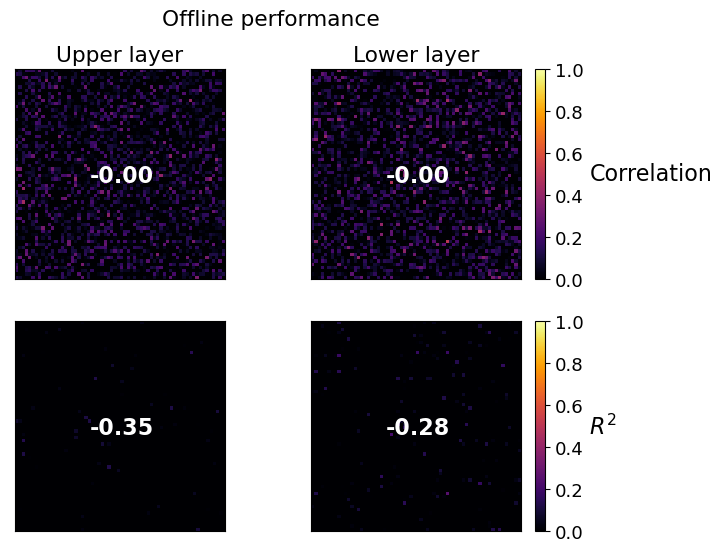

In [55]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds_q_qtot_wonly.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds_q_qtot_wonly.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

---
## 5. WDL + NN <a class="anchor" id="5"></a>

In [38]:
%run nnClassW.ipynb

In [39]:
fcnn_param_w = FCNNParameterization_w('./models/fcnn_q_qtot_w')

In [40]:
fcnn_param_w = fcnn_param_w.train_on(dataset = eddy_forcing1, inputs=in_q, targets=tar_q_tot, directory = './models/fcnn_q_qtot_w')

Loss after Epoch 1: 1.7458446318067766


/Users/peterjin/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Loss after Epoch 2: 1.504232598370508
Loss after Epoch 3: 1.604014748148386
Loss after Epoch 4: 1.8490876478609404
Loss after Epoch 5: 1.38069812095701
Loss after Epoch 6: 2.0443303836750033
Loss after Epoch 7: 1.415812504164182
Loss after Epoch 8: 1.8348732847836677
Loss after Epoch 9: 1.314762340601564
Loss after Epoch 10: 1.168358837780781
Loss after Epoch 11: 1.4678561332988775
Loss after Epoch 12: 1.152367034371405
Loss after Epoch 13: 1.2250736473059243
Loss after Epoch 14: 0.9543082581518756
Loss after Epoch 15: 1.2488748319466616
Loss after Epoch 16: 0.7054600364847601


ValueError: Expected parameter scale (Tensor of shape (4096, 3)) of distribution Normal(loc: torch.Size([4096, 3]), scale: torch.Size([4096, 3])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[0.0351, 0.0198, 0.0039],
        [0.0475, 0.0268, 0.0053],
        [0.0472, 0.0267, 0.0053],
        ...,
        [0.0870, 0.0491, 0.0097],
        [0.0874, 0.0493, 0.0098],
        [0.1255, 0.0709, 0.0140]], grad_fn=<AbsBackward0>)

In [ ]:
preds_q_qtot_w = fcnn_param_w.test_offline(eddy_forcing1) # this should return (near) 100 accuracy since it's trained on this dataset...

In [ ]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds_q_qtot_w.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds_q_qtot_w.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

---
## 6. PCA/CCA on input/output <a class="anchor" id="6"></a>

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn import preprocessing

###### PCA on input:

In [ ]:
t_pca = 50
q_pca = preprocessing.normalize(eddy_forcing1['q'][t_pca][0])
pca = PCA(n_components=15).fit(q_pca)

plt.scatter(q_pca[:, 0], q_pca[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# plot cumsum -- let total var -> 98-99

###### PCA on target:

In [ ]:
qtar_pca = preprocessing.normalize(eddy_forcing1['q_forcing_total'][t_pca][0])
pcatar = PCA(n_components=25).fit(qtar_pca)

plt.scatter(qtar_pca[:, 0], qtar_pca[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pcatar.components_, pcatar.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

In [ ]:
PCtar_values = np.arange(pcatar.n_components_) + 1
plt.plot(PCtar_values, pcatar.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

###### CCA:

In [ ]:
# print errors
q_cca = preprocessing.normalize(eddy_forcing1['q'][t_pca][0])
cca = CCA(n_components=6).fit(q_cca,qtar_pca)